In [1]:
from datetime import datetime
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
from supabase import create_client
#from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.output_parsers import StrOutputParser
from typing import Annotated, Callable
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.schema import Document
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Literal
from typing import List
from typing_extensions import TypedDict
from langchain.tools.retriever import create_retriever_tool
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from pprint import pprint
from typing import Any,  Literal, Union
from langchain_core.messages import  AnyMessage
from langchain.schema import AIMessage
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.runnables import Runnable, RunnableConfig
from typing import Annotated, Literal, Optional
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode
import logging
import os

In [2]:
import tools_restaurant

In [3]:
import supabase_service

Supabase client initialized: <supabase._sync.client.SyncClient object at 0x0000026BCFCA1190>


In [4]:
import tools

In [5]:
load_dotenv()
DB_CONNECTION = os.getenv("DB_CONNECTION")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_KEY")
TABLE_NAME = os.getenv("TABLE_NAME")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_TRACING_V2=os.getenv("LANGCHAIN_TRACING_V2")




chat = ChatOpenAI(model="gpt-4o", temperature=0)
# Crear cliente de Supabase
supabase = create_client(SUPABASE_URL, SUPABASE_KEY)
embeddings = OpenAIEmbeddings()  # Inicializar embeddings
vector_store = supabase_service.load_vector_store()
retriever=vector_store.as_retriever(search_kwargs={"k":4})
#memory = SqliteSaver.from_conn_string(":memory:") #despues se conecta a bd
memory=MemorySaver()






#LLM with function call
llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_tools=tools.TOOLS
agent= llm.bind_tools([tools.tool_create_event_test_drive,tools.toRagAssistant])


#Prompt

system="""
You are a customer support assistant at Los Coches, a car dealership offering a wide range of vehicles. 
Your role is to assist customers by:

Answering Questions: Provide detailed, accurate, and helpful information about the vehicles available. 
This includes specifications, features, pricing, availability, and any current promotions or financing options.
Only the specialized assistant is given the permission to do this for the customer. 

The customer is not aware of the different specialized assistant, so do not mention them; just quietly delegate 
through function calls. 

Scheduling Appointments: Help customers set up appointments for test drives. 
Collect necessary information such as their name, email, preferred date and time, and the specific vehicle models they are interested in. If the user want to add comments, let him, but it is optional
The dates must be in the following format :  YYYY-MM-DDTHH:MM:SS-05:00. Quietly add the UTC format wihtout asking the user.
Dont show the user the format you are using, only ask day and hour. 
Make sure the user input fields are in the proper format

Professional Interaction:Communicate in a friendly, professional, and courteous manner. 
Ensure that all customer inquiries are addressed promptly and thoroughly.

Your goal is to enhance the customer experience by providing excellent service and facilitating their journey towards purchasing a vehicle from Los Coches.
You must answer in Spanish

Current time = {time}
"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{input}"),
        ("placeholder","{messages}"),
        
    ]
).partial(time=datetime.now())

main_agent=prompt | agent





### Generate
#llm 
llm = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools([tools.CompleteOrEscalate])

system="""
You are a specialized customer support assistant for Los Coches, a car dealership renowned for its wide selection of vehicles. 
Your main function is to answer any requests customers have about Los Coches and the cars they offer.

Access to Context: You have comprehensive knowledge and access to detailed information about all vehicles in the Los Coches inventory. 
This includes specifications, features, pricing, availability, customer reviews, and current promotions or financing options. 
Use the  context provided below to give accurate and helpful responses to customer inquiries.

Customer Inquiries: Assist customers with any questions they may have about specific car models, compare different vehicles, 
provide recommendations based on their preferences and needs, and inform them about additional services offered by Los Coches

If the context provided is not enough to answer the user inquiries, then CompleteOrEscalate
If the customer changes their mind, escalate the task back to the main assistant.
If the customer needs help and your function is not appropriate to answer him, then CompleteOrEscalate.
If the customer input is not about inquiries related to the car dealership, you must CompleteOrEscalate.
You must answer in Spanish
Customer request : {user_input}

Context : {context}

time : {time}

"""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{user_input}"),
        ("placeholder", "{messages}")
    ]
).partial(time=datetime.now())

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_agent = prompt | llm 


### Question Re-writer

llm = ChatOpenAI(model="gpt-4o", temperature=0)

system="""

You are an AI assistant that rewrites follow-up questions into fully self-contained questions. 
Your goal is to make the questions clear and specific so they can be effectively used to retrieve information from a vector store about a car dealership.
Instructions:
Understand the Context:

Review the conversation history to grasp the context and gather necessary details.
Identify entities like car models, features, pricing, availability, and any other relevant information mentioned earlier.
Rewrite the Question:

Transform the follow-up question into a complete, standalone question.
Incorporate relevant context from the conversation history.
Maintain the original intent and meaning of the user's question.
Ensure Clarity and Specificity:

Use clear and precise language.
Avoid ambiguity and generalities.
Ensure the question is specific enough to retrieve accurate information from the vector store.
Keep it Professional and Neutral:

Use a neutral tone appropriate for a customer-service setting.
Do not include personal opinions or additional information not present in the conversation history
Example:

Conversation History:

User: "I'm interested in the latest SUV models."
Assistant: "We have the 2023 X-Series and the 2023 Y-Series SUVs available."
User: "What about safety features?

Follow-up Question:

"What about safety features?"

Rewritten Question:

"What safety features are included in the 2023 X-Series and 2023 Y-Series SUVs available at your dealership?

You must answer in SPANISH
"""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("placeholder","{messages}"),
        (
            "human", "{question}",
        )
    ]
)

question_rewriter = re_write_prompt | llm 
#question_rewriter.invoke({"question": question})



###Graph state

def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    user_input:str
    messages : Annotated[list, add_messages]
    dialog_state : Annotated[list[Literal["primary_assistant","rag_assistant"]],update_dialog_stack]



### Nodes

def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: GraphState) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

def primary_assistant(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the input, it will decide to use any tool, retrieve info, or keep chatting.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    
    user_input=state['messages'][-1]
    
    response=main_agent.invoke({"input":user_input,"messages":state['messages']})

    return {"messages": [response],"user_input":user_input.content}

def rag_assistant(state):

    if state['messages'][-2].tool_calls:
        user_input=state['messages'][-2].tool_calls[0]['args']['request']
    else :
        user_input = state['messages'][-1].content
    
    #improved_input=question_rewriter.invoke({"question":user_input,"messages":state["messages"]}).content
     #Extrae contexto segun el query
    context= retriever.invoke(user_input)

    #Responde de acuerdo al contexto
    response= rag_agent.invoke({"user_input":user_input,"messages":state["messages"],"context":context})

    return {"messages": [response]}





### Edges ###


#Define tool routing


def route_primary_assistant(
    state: GraphState,
) -> Literal[
    "enter_rag_assistant",
    "tools",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == tools.toRagAssistant.__name__:
            return "enter_rag_assistant"
        elif tool_calls[0]["name"] == "create_event_test_drive":
            return "tools"
    raise ValueError("Invalid route")

def route_to_workflow(
    state: GraphState,
) -> Literal[
    "primary_assistant",
    "rag_assistant",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]

def route_assistants(
    state: GraphState,
) -> Literal[
    "leave_skill",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == tools.CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"

# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: GraphState) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the student as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


In [6]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_conditional_edges(START,route_to_workflow)
workflow.add_node("primary_assistant",primary_assistant)

workflow.add_node("enter_rag_assistant", create_entry_node("RAG assistant", "rag_assistant"))  
workflow.add_node("rag_assistant", rag_assistant)
workflow.add_edge("enter_rag_assistant","rag_assistant")

workflow.add_node("tools",ToolNode([tools.create_event_test_drive]))
workflow.add_edge("tools","primary_assistant")

workflow.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    {
        "enter_rag_assistant": "enter_rag_assistant",
        "tools": "tools",
        END: END,
    },
)
workflow.add_conditional_edges("rag_assistant", route_assistants)
workflow.add_node("leave_skill",pop_dialog_state)
workflow.add_edge("leave_skill", "primary_assistant")


In [7]:
app = workflow.compile(checkpointer=memory)

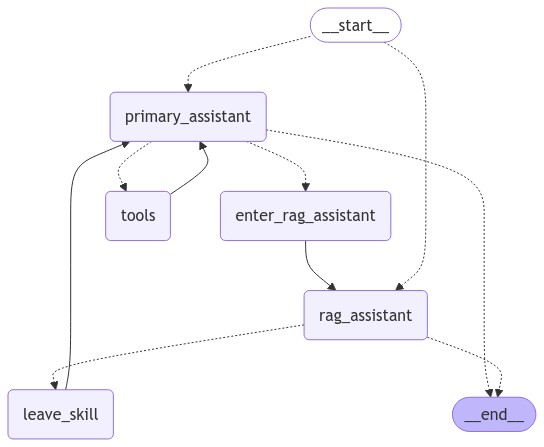

In [8]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
config={"configurable":{"thread_id":11}}
lista=["hola"]
for i in lista:
    for event in app.stream({"messages": ("user", i)},config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


---CALL AGENT---
Assistant: ¡Hola! Bienvenido a Los Coches. ¿En qué puedo ayudarte hoy? ¿Estás interesado en obtener información sobre algún vehículo en particular o te gustaría agendar una cita para un test drive?


In [10]:

lista=["Quiero cotizar el reanalut captur"]
for i in lista:
    for event in app.stream({"messages": ("user", i)},config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

---CALL AGENT---
Assistant: 
Assistant: The assistant is now the RAG assistant. Reflect on the above conversation between the host assistant and the user. The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are RAG assistant, If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control. Do not mention who you are - just act as the proxy for the assistant.
Assistant: ¡Perfecto! Para poder proporcionarte una cotización más precisa del Renault Captur, necesito saber el año y la versión específica que te interesa. Los modelos disponibles para el año 2025 son:

1. Renault Captur Life 1.6L MT 4x2
2. Renault Captur Intens 1.3T CVT 4x2
3. Renault Captur Iconic 1.3T CVT 4x2

Por favor, indícame cuál de estas versiones te interesa cotizar.


In [11]:

lista=["Dame información detallada sobre el primero"]
for i in lista:
    for event in app.stream({"messages": ("user", i)},config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Claro, aquí tienes la información detallada sobre el **Renault Captur Life 1.6L MT 4x2 (2025)**:

### Motor y Rendimiento:
- **Motor**: 1.6L, 4 cilindros
- **Potencia**: 115 HP @ 5.500 rpm
- **Torque**: 156 Nm @ 4.000 rpm
- **Transmisión**: Manual de 5 velocidades + reversa
- **Tracción**: 4x2 (delantera)
- **Consumo de combustible**: Aproximadamente 14 km/l en ciudad y 18 km/l en carretera
- **Aceleración de 0 a 100 km/h**: 12.8 segundos
- **Consumo mixto**: 45 km/gal

### Dimensiones y Capacidades:
- **Longitud**: 4,412 mm
- **Ancho**: 1,813 mm
- **Altura**: 1,622 mm
- **Distancia entre ejes**: 2,673 mm
- **Capacidad del maletero**: 437 litros, ampliable a 1,275 litros
- **Capacidad del tanque de combustible**: 50 litros
- **Peso en orden de marcha**: 1,250 kg
- **Carga útil**: 550 kg
- **Altura al piso**: 211 mm

### Equipamiento de Seguridad:
- **Frenos**: Discos ventilados delanteros, frenos traseros de tambor
- **Frenos ABS con EBD** (Distribución Electrónica de Frenad

In [12]:

lista=["Quiero agendar un test drive"]
for i in lista:
    for event in app.stream({"messages": ("user", i)},config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: ¡Perfecto! Para agendar un test drive del Renault Captur Life 1.6L MT 4x2, necesito algunos datos adicionales:

1. **Nombre completo**:
2. **Número de contacto**:
3. **Correo electrónico**:
4. **Fecha y hora preferida para el test drive**:
5. **Concesionario de preferencia** (si tienes alguno en mente):

Por favor, proporciona esta información para que podamos coordinar tu prueba de manejo.


In [13]:

lista=["mentiras, quiero cotizar el renault kangoo"]
for i in lista:
    for event in app.stream({"messages": ("user", i)},config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: Resuming dialog with the host assistant. Please reflect on the past conversation and assist the student as needed.
---CALL AGENT---
Assistant: 
Assistant: The assistant is now the RAG assistant. Reflect on the above conversation between the host assistant and the user. The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are RAG assistant, If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control. Do not mention who you are - just act as the proxy for the assistant.
Assistant: Para proporcionarte una cotización precisa del Renault Kangoo, necesito saber el año y la versión específica que te interesa. Los modelos disponibles para el año 2025 son:

1. Renault Kangoo Express 1.6L MT
2. Renault Kangoo Express 1.5L dCi MT
3. Renault Kangoo Passenger 1.6L MT

Por favor, indícame cuál de estas versiones te interesa cotizar.


In [14]:

lista=["y cual es su velocidad maxima"]
for i in lista:
    for event in app.stream({"messages": ("user", i)},config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: La velocidad máxima de las versiones del Renault Kangoo 2025 es la siguiente:

1. **Renault Kangoo Express 1.6L MT**: 170 km/h
2. **Renault Kangoo Express 1.5L dCi MT**: 160 km/h
3. **Renault Kangoo Passenger 1.6L MT**: 170 km/h

Si necesitas más información o deseas proceder con la cotización, por favor indícame la versión específica que te interesa.


In [10]:
inputs={"messages": "hola"}
config={"configurable": {"thread_id":"13"}}
for output in app.stream(inputs,config=config):
    for key, value in output.items():
        pprint(f"Node '{key}':")
        pprint(value, indent=2, width=80, depth=None)
        if 'messages' in value:
            output_message=value["messages"][-1]
            if isinstance(output_message,AIMessage) and output_message.content!='':
                message=output_message.content    
                print(message)
    pprint("\n---\n")

---CALL AGENT---
"Node 'primary_assistant':"
{ 'messages': [ AIMessage(content='¡Hola! ¿En qué puedo ayudarte hoy en Los Coches?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 517, 'total_tokens': 532, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_a5d11b2ef2', 'finish_reason': 'stop', 'logprobs': None}, id='run-8370940b-d9b1-41f8-b289-c7ad80020791-0', usage_metadata={'input_tokens': 517, 'output_tokens': 15, 'total_tokens': 532})],
  'user_input': 'hola'}
¡Hola! ¿En qué puedo ayudarte hoy en Los Coches?
'\n---\n'


In [11]:
inputs={"messages": "Quiero agendar un test drive"}
config={"configurable": {"thread_id":"13"}}
for output in app.stream(inputs,config=config):
    for key, value in output.items():
        pprint(f"Node '{key}':")
        pprint(value, indent=2, width=80, depth=None)
        if 'messages' in value:
            output_message=value["messages"][-1]
            if isinstance(output_message,AIMessage) and output_message.content!='':
                message=output_message.content    
                print(message)
    pprint("\n---\n")

---CALL AGENT---
"Node 'primary_assistant':"
{ 'messages': [ AIMessage(content='¡Perfecto! Me encantaría ayudarte a agendar un test drive. \n\nPara proceder, necesito algunos detalles:\n\n1. Tu nombre y apellido.\n2. Tu correo electrónico.\n3. El modelo del coche que te gustaría probar.\n4. El día y la hora que prefieres para el test drive.\n5. Cualquier comentario adicional que desees agregar (opcional).\n\nPor favor, proporciona esta información para que pueda agendar tu cita.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 552, 'total_tokens': 644, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_a5d11b2ef2', 'finish_reason': 'stop', 'logprobs': None}, id='run-383141d7-e33e-413b-859b-883d864d9abc-0', usage_metadata={'input_tokens': 552, 'output_tokens': 92, 'total_tokens': 644})],
  'user_input': 'Quiero agendar un test drive'}
¡Perfecto! Me encantar

In [12]:
inputs={"messages": "Me llamo Benito Camelo, mi correo es ppp777 , agendalo para pasado mañana a las 9 am"}
config={"configurable": {"thread_id":"13"}}
for output in app.stream(inputs,config=config):
    for key, value in output.items():
        pprint(f"Node '{key}':")
        pprint(value, indent=2, width=80, depth=None)
        if 'messages' in value:
            output_message=value["messages"][-1]
            if isinstance(output_message,AIMessage) and output_message.content!='':
                message=output_message.content    
                print(message)
    pprint("\n---\n")

---CALL AGENT---
"Node 'primary_assistant':"
{ 'messages': [ AIMessage(content='Gracias por la información, Benito. Solo necesito saber el modelo del coche que te gustaría probar para completar la cita.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 694, 'total_tokens': 718, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_a5d11b2ef2', 'finish_reason': 'stop', 'logprobs': None}, id='run-1f68ee3e-c837-45a5-9e60-b9b6d0517c63-0', usage_metadata={'input_tokens': 694, 'output_tokens': 24, 'total_tokens': 718})],
  'user_input': 'Me llamo Benito Camelo, mi correo es ppp777 , agendalo para '
                'pasado mañana a las 9 am'}
Gracias por la información, Benito. Solo necesito saber el modelo del coche que te gustaría probar para completar la cita.
'\n---\n'


In [13]:
inputs={"messages": "El renault koleos"}
config={"configurable": {"thread_id":"13"}}
for output in app.stream(inputs,config=config):
    for key, value in output.items():
        pprint(f"Node '{key}':")
        pprint(value, indent=2, width=80, depth=None)
        if 'messages' in value:
            output_message=value["messages"][-1]
            if isinstance(output_message,AIMessage) and output_message.content!='':
                message=output_message.content    
                print(message)
    pprint("\n---\n")

---CALL AGENT---
"Node 'primary_assistant':"
{ 'messages': [ AIMessage(content='Gracias, Benito. Solo una pequeña corrección: tu correo electrónico parece estar incompleto. ¿Podrías confirmarlo nuevamente, por favor?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 711, 'total_tokens': 741, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_a5d11b2ef2', 'finish_reason': 'stop', 'logprobs': None}, id='run-979c64e2-1721-42fc-9020-0fd151ec510e-0', usage_metadata={'input_tokens': 711, 'output_tokens': 30, 'total_tokens': 741})],
  'user_input': 'El renault koleos'}
Gracias, Benito. Solo una pequeña corrección: tu correo electrónico parece estar incompleto. ¿Podrías confirmarlo nuevamente, por favor?
'\n---\n'


In [14]:
inputs={"messages": "ppp777@gmail.com"}
config={"configurable": {"thread_id":"13"}}
for output in app.stream(inputs,config=config):
    for key, value in output.items():
        pprint(f"Node '{key}':")
        pprint(value, indent=2, width=80, depth=None)
        if 'messages' in value:
            output_message=value["messages"][-1]
            if isinstance(output_message,AIMessage) and output_message.content!='':
                message=output_message.content    
                print(message)
    pprint("\n---\n")

---CALL AGENT---
"Node 'primary_assistant':"
{ 'messages': [ AIMessage(content='¡Perfecto! Ahora tengo toda la información necesaria. Procederé a agendar tu test drive para el Renault Koleos.\n\nVoy a agendarlo para pasado mañana a las 9:00 AM. Un momento, por favor.', additional_kwargs={'tool_calls': [{'id': 'call_WdRs335LafjzVY7gqpd7jSdv', 'function': {'arguments': '{"car_model":"Renault Koleos","name":"Benito","lastname":"Camelo","email":"ppp777@gmail.com","date_begin":"2024-09-19T09:00:00-05:00","date_finish":"2024-09-19T10:00:00-05:00"}', 'name': 'create_event_test_drive'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 127, 'prompt_tokens': 753, 'total_tokens': 880, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_a5d11b2ef2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6622411c-8848-4316-8dd3-dad2b40c86eb-0', tool_calls=[{'name': 'create_event_test_dr